In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from functools import partial

## Load and inspect data

In [2]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
print('X_train shape:', X_train_full.shape)
print('X_train dtype:', X_train_full.dtype)
print('X_train max:', X_train_full.max(), '\nX_train min:', X_train_full.min())

X_train shape: (60000, 28, 28)
X_train dtype: uint8
X_train max: 255 
X_train min: 0


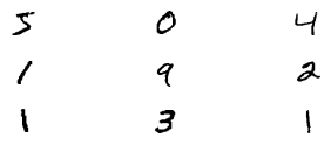

y values: [5 0 4 1 9 2 1 3 1]


In [3]:
X_new = X_train_full[:9]
# Image representations of first 9 digits
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Corrosponding y vals
print('y values:',y_train_full[:9])

In [4]:
# Define the classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Split train and valid
X_valid, X_train = X_train_full[:5000]/255, X_train_full[5000:]/255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255

## Model

In [5]:
RegularisedDense = partial(keras.layers.Dense,
                           activation='relu')

# Create a sequenial model
model = keras.models.Sequential([
    # Input layer
    keras.layers.Flatten(input_shape=[28,28]),
    # Hidden layers
    RegularisedDense(300),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    RegularisedDense(300),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    # Output layer
    keras.layers.Dense(10, activation='softmax')
    ])
model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0

In [6]:
# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum = 0.9, decay=1e-4),
              metrics='accuracy')

In [7]:
# Create logs
root_logdir = os.path.join(os.curdir+'mnist_logs')
def get_run_log():
    import time
    run_id = time.strftime('run_%Y_%m_%d_%H_%M_%S')
    return os.path.join(root_logdir, run_id)
# Tensorboard 
runlog_dir = get_run_log()
tensorboard_cb = keras.callbacks.TensorBoard(runlog_dir)
# Save by step and introduce early stopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('models/checkpoint_model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/50
1719/1719 [==============================] - 22s 12ms/step - loss: 0.4159 - accuracy: 0.8746 - val_loss: 0.1067 - val_accuracy: 0.9668
Epoch 2/50
1719/1719 [==============================] - 20s 12ms/step - loss: 0.1541 - accuracy: 0.9533 - val_loss: 0.0833 - val_accuracy: 0.9752
Epoch 3/50
1719/1719 [==============================] - 20s 12ms/step - loss: 0.1218 - accuracy: 0.9624 - val_loss: 0.0763 - val_accuracy: 0.9796
Epoch 4/50
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0988 - accuracy: 0.9694 - val_loss: 0.0656 - val_accuracy: 0.9816
Epoch 5/50
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0848 - accuracy: 0.9727 - val_loss: 0.0592 - val_accuracy: 0.9822
Epoch 6/50
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0758 - accuracy: 0.9753 - val_loss: 0.0615 - val_accuracy: 0.9834
Epoch 7/50
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0694 - accuracy: 0.9773 - val_loss: 0.0562 -

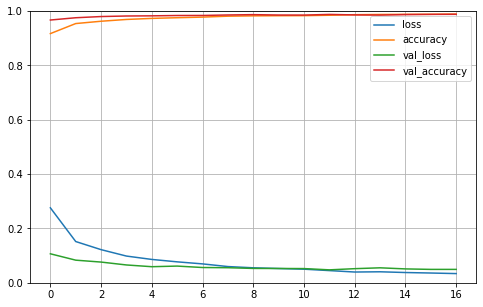

In [8]:
# Plot history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [9]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.0515 - accuracy: 0.9845


[0.05151403695344925, 0.984499990940094]

In [10]:
X_sample = X_test[:3]
y_prob = model.predict(X_sample)
y_prob.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
y_pred = np.argmax(model.predict(X_sample), axis=-1)
y_pred

array([7, 2, 1], dtype=int64)

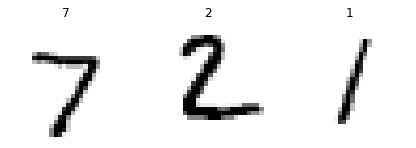

In [12]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_sample):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [13]:
model.save('models/98%.h5')